# Initializing QTLab stuff

In [1]:
%run C:\qtlab_replacement\init.py
from instruments import *
import numpy as np
import sweep
import pandas as pd
from save_pkl import *
from IPython.display import clear_output

root: WARNING  Unable to load config file.


In [2]:
import os
os.chdir("C:\qtlab_replacement\instruments\_labbrick")

# Iniatializing Plotting and auxilary tools

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.ticker
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import pickle
import re

# Anritsu MS2830A Signal Analizer

In [4]:
sa = Anritsu_MS2830A('signal_analyzer', address = 'GPIB0::5::INSTR')

In [5]:
sa.set_nop(1001)

True

In [6]:
#sa.set_startfreq(5.8e9)
#sa.set_stopfreq(6.2e9)
sa.set_frequency(6.5e9)
sa.set_span(10e4)
sa.set_nop(1001)
sa.set_bandwidth(1000)
sa.set_averages(10)

True

In [7]:
sa.get_sweep_time()

2000.0

In [8]:
freqs = sa.get_freqpoints()
data = sa.get_tracedata()

Text(0, 0.5, 'power (dBm)')

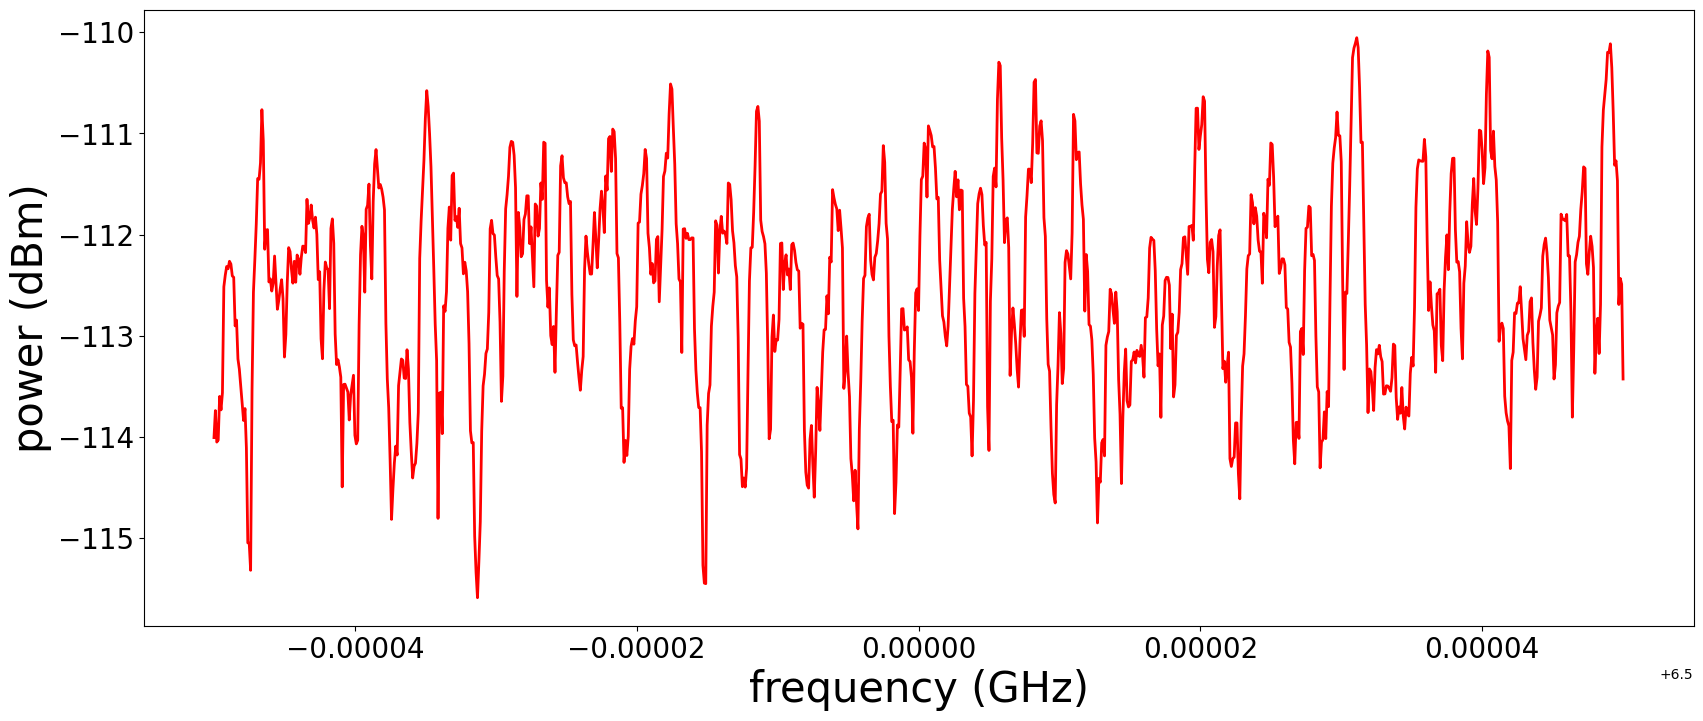

In [9]:
fig, axes = plt.subplots(1,1,figsize=(20, 8))

p = axes.plot(freqs/1e9, data, linewidth=2.0, c = 'r')

#axes.axis('tight')
axes.set_xlabel(r'frequency (GHz)', fontsize=30)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel(r'power (dBm)', fontsize=30)

In [10]:
sa.get_centerfreq()

6500000000.0

In [11]:
sa.set_centerfreq(8)

True

# Lab brick

In [12]:
get_labbricks()

{1: {'name': 'LMS-183DX', 'serial_number': 27937}}

In [13]:
lo_ro = Labbrick(name='LMS-183DX', serial=27937)

In [14]:
lo_ro.set_power(-55)
lo_ro.get_power()

7.0

In [15]:
lo_ro.set_status(False)
lo_ro.set_power(13)
lo_ro.set_frequency(6.500e9)

True

In [16]:
lo_ro.set_status(False)

True

# Scalar mixer test 

In [186]:
lo_ro.set_power(7)
lo_ro.set_frequency(6.1e9)

sa.set_frequency(6.1e9)
sa.set_span(1000e3)
sa.set_nop(10001)
sa.set_bandwidth(20)
sa.set_averages(2)

True

In [187]:
sa.get_sweeptime()

4.8

In [188]:
sa.set_continuous_mode(0)

True

In [189]:
lo_ro.set_status(True)
freqs = sa.get_freqpoints()
data_off = sa.get_tracedata()
lo_ro.set_status(False)

True

In [169]:
lo_ro.set_status(True)
freqs = sa.get_freqpoints()
data_on = sa.get_tracedata()
lo_ro.set_status(False)

True

Text(0, 0.5, 'power (dBm)')

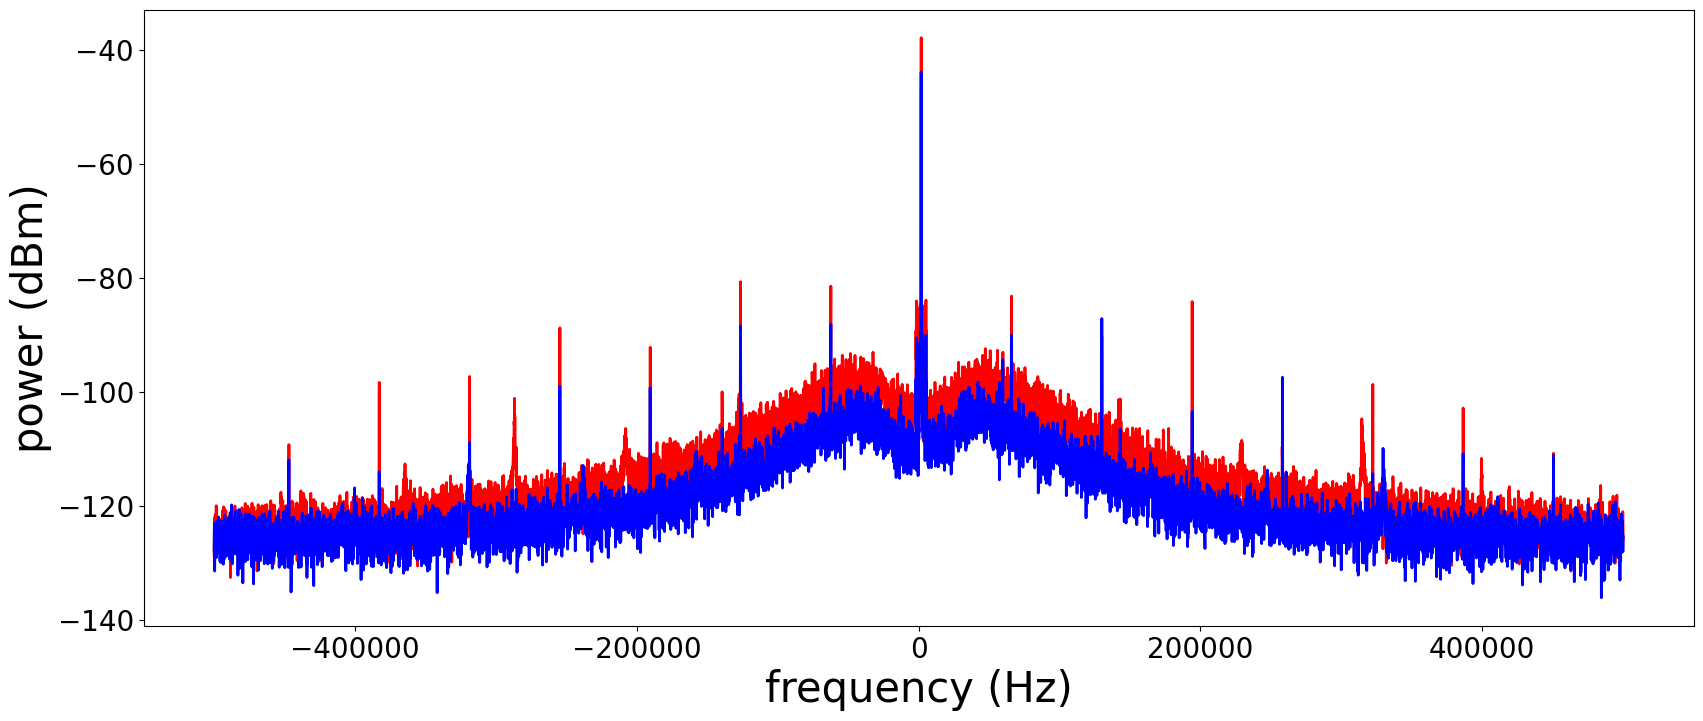

In [190]:
fig, axes = plt.subplots(1,1,figsize=(20, 8))

p = axes.plot(freqs-6.1e9, data_off, linewidth=2.0, c = 'r')
p = axes.plot(freqs-6.1e9, data_on, linewidth=2.0, c = 'b')

#axes.axis('tight')
axes.set_xlabel(r'frequency (Hz)', fontsize=30)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel(r'power (dBm)', fontsize=30)

# Markers

In [173]:
sa.set_marker_freq(6.1e9,1)
sa.set_marker_freq(6.1e9-25e6,2)
sa.set_marker_freq(6.1e9+25e6,3)

In [66]:
sa.set_marker_zone_width(5e6,2)

In [67]:
#sa.set_marker_integration_type('INT')
sa.set_marker_integration_type('DENS')
#sa.set_marker_integration_type('PEAK')

In [174]:
print('RF value:',  sa.get_marker_value(1), 'dBm')
print('USB value:', sa.get_marker_value(3), 'dBm')
print('LSB value:', sa.get_marker_value(2), 'dBm')

RF value: -94.57 dBm
USB value: -94.58 dBm
LSB value: -126.26 dBm


# PXIe AWG

In [17]:
import sys
import os
#os.chdir("C:\qtlab_replacement\instruments\_labbrick")
import numpy as np
sys.path.append('C:\Program Files\Keysight\SD1\Libraries\Python')
import keysightSD1

In [18]:
CHASSIS  = 1
SLOT_IN  = 7
SLOT_OUT = 5
awg = Keysight_M3201A_S('awg', CHASSIS, SLOT_OUT)   # C:\qtlab_replacement\instruments\_Keysight_M3201A\simple_sync.py

In [19]:
marker_length = 100
#readout_trigger_delay = 185
readout_trigger_delay = 0
trg_length = 10e-9

ex_clock = 1000e6
ro_clock = 1250e6

rep_rate = 20e3                                      # repetition rate of the experiment
global_num_points = 50000-500   #-500

awg.stop()
awg.check_cached = True
awg.set_clock(ex_clock)
awg.set_clock_output(True)
awg.set_nop(ex_clock/rep_rate)                    
awg.repetition_period = global_num_points

awg.get_clock = lambda: 1e9

In [20]:
print('AWG parameters: ')
print('Number of poinst:', awg.get_nop())
print('Channel Amplitudes:',awg.get_amplitude(0),'V',awg.get_amplitude(1),'V',awg.get_amplitude(2),'V',awg.get_amplitude(3),'V')
print('Clock:', round(awg.get_clock()),'ns')
print('Repetition_period:', round(awg.get_repetition_period()/1e9),'ns')

AWG parameters: 
Number of poinst: 49500
Channel Amplitudes: 0.2 V 0.2 V 0.2 V 0.2 V
Clock: 1000000000 ns
Repetition_period: 49500 ns


In [21]:
# channel 0 is master and triggers all others
awg.trigger_source_types = [6, 6,6,6]                 # Trigger source (soft,hard etc) 6  external per cycle, 0 -soft (from PC)
awg.trigger_source_channels = [4000, 4000,4000,4000]  # External trigger source. 0 means PXI trigger, 4000+
awg.trigger_delays = [0,0,0,0]                        # Master channel should wait 400 ns for others to start
awg.trigger_behaviours = [4,4,4,4]                    # Rising/Falling edge etc 4 - Falling

In [155]:
wf   = np.sin(np.linspace(-np.pi,np.pi,awg.get_nop(), endpoint=False)*20)
wf_d = np.asarray(wf).tolist()

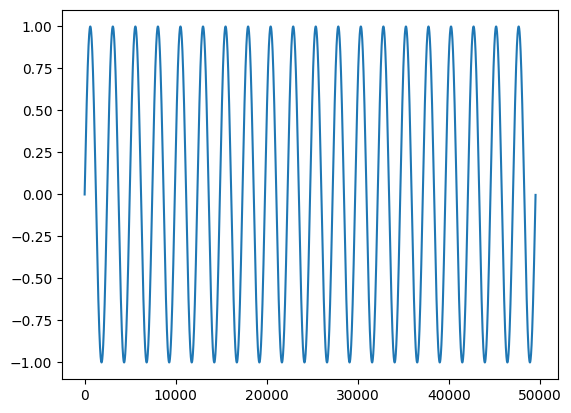

In [156]:
plt.plot(wf_d)

In [159]:
awg.trigger_source_types = [0,6,6,6]
awg.trigger_source_channels = [0, 4000,4000,4000]
awg.trigger_delays = [40, 0,0,0]
awg.trigger_behaviours = [0,4,4,4]
awg.set_trigger_mode(2)
for channel in range(0,4):
    awg.set_amplitude(1, channel = channel)
    awg.set_offset(0.0, channel = channel)
    awg.set_output(1, channel = channel)
    awg.set_waveform(waveform = wf_d, channel = channel)

In [158]:
awg.set_marker(length = 200, delay = 0, channel = 0, pxi_channels = 1)

In [160]:
awg.run()

In [161]:
awg.stop()

In [22]:
from libraries import awg_digital

In [23]:
awg_channels = dict()
ro_trg = awg_digital.awg_digital(awg, 1)
ro_trg.mode = 'set_delay' #M3201A
ro_trg.delay_setter = lambda x: adc.set_trigger_delay(int(x*adc.get_clock()/iq_ex.get_clock()-readout_trigger_delay)) #M3201A
awg_channels['ro_trg'] = ro_trg

# Qubit Parameters

In [24]:
#Qubit Parameters. All keys should be str

Qubits = {'1':{'r':{'Fr': 6.1e9, 'P':-50}, 
               'q':{'F':
                    {'F01_max':6.6e9,
                    'F01_mid':6.1e9}
                    }}#,
        # '2':{'r':{'Fr': 8.35e9, 'P':-50}, 
        #       'q':{'00-1-01': 4.250412e9,
        #            }}
         }
qubit_params = Qubits
qubits = Qubits
qubit_id = '1'

# Pulses

In [33]:
from libraries import pulses as pulses
from libraries import awg_iq_multi
import imp
imp.reload(awg_iq_multi)

<module 'libraries.awg_iq_multi' from 'C:\\qtlab_replacement\\libraries\\awg_iq_multi.py'>

In [34]:
#lo_freq = 11.666e9
lo_ro_freq = 6.1e9
_qubit_id='1'

In [35]:
lo_ro.set_status(False)
#lo1.set_frequency(lo_freq)
lo_ro.set_frequency(lo_ro_freq)

True

In [36]:
from ponyfiles.exdir_db import exdir_db

In [39]:
exdir_db

ponyfiles.exdir_db.exdir_db

In [38]:
iq_ro = awg_iq_multi.awg_iq_multi(awg, awg, 0, 1, lo_ro, exdir_db) #M3201A
#iq_ex = awg_iq_multi.awg_iq_multi(awg2, awg2, 2, 3, lo_ex) #M3201A

In [40]:
readout_channels = {}

In [41]:
awg_iq_multi.carrier(iq_ro)

In [42]:
iq_ro.carriers['iq_ro_q{}'.format(_qubit_id)] = awg_iq_multi.carrier(iq_ro)

In [43]:
qubits[_qubit_id]['q']['F'].items()

dict_items([('F01_max', 6600000000.0), ('F01_mid', 6100000000.0)])

In [44]:
for tr, freq in qubits[_qubit_id]['q']['F'].items():
    iq_ro.carriers['iq_ro_q{}'.format(_qubit_id)] = awg_iq_multi.carrier(iq_ro)
    iq_ro.carriers['iq_ro_q{}'.format(_qubit_id)].set_frequency(qubits[_qubit_id]['r']['Fr'])
    #iq_ex.carriers['iq_ex_q{}'.format(_qubit_id)] = awg_iq_multi.carrier(iq_ex)
    #iq_ex.carriers['iq_ex_q{}'.format(_qubit_id)].set_frequency(qubits[_qubit_id]['q']['F']['F01_mid'])
    awg_channels['iq_ro_q{}'.format(_qubit_id)] = iq_ro.carriers['iq_ro_q{}'.format(_qubit_id)]
    #awg_channels['iq_ex_q{}'.format(_qubit_id)] = iq_ex.carriers['iq_ex_q{}'.format(_qubit_id)]
    readout_channels['iq_ro_q{}'.format(_qubit_id)] = awg_channels['iq_ro_q{}'.format(_qubit_id)]

In [45]:
pg = pulses.pulses(awg_channels)

In [46]:
print("Readout channel", end='\n')
iq_ro.do_calibration(sa)

Readout channel
Calibrate DC for device <bound method Instrument.get_name of <_Keysight_M3201A.simple_sync.Keysight_M3201A_S object at 0x0000017205EA9340>> channels 0, 1 

<class 'TypeError'> select_measurement() missing 1 required positional argument: 'self'
6100000000.0
Trying to set too large value: 4000000.0


AttributeError: 'Anritsu_MS2830A' object has no attribute 'set_detector'